# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

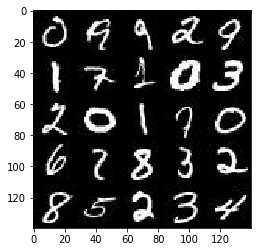

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

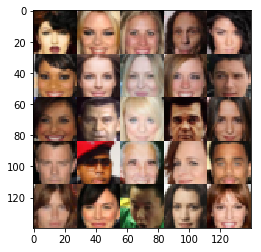

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [57]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [58]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #2x2x512
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*512)

        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #2x2x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [op for op in update_ops if op.name.startswith('generator')]
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [67]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.4419
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 12.1587
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 6.9943
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 6.1426
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 3.2361
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.8437
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.5323
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 3.7958
Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 1.6182


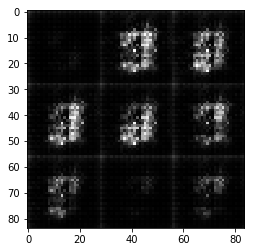

Epoch 1/2... Discriminator Loss: 0.2304... Generator Loss: 3.0347
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 4.4389
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.0127
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 1.6063
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 2.2953
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.7422... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.1348


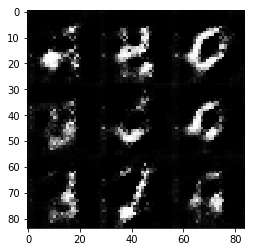

Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.2542
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 2.1902
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.7319


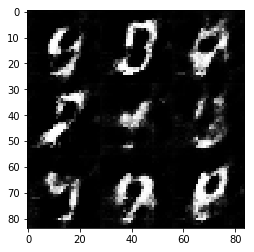

Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 0.5945
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 1.1202
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.0982


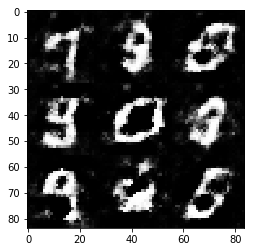

Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.6889... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 1.7356


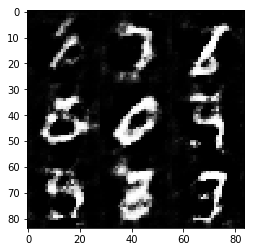

Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 1.3086
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 0.2717
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.3557


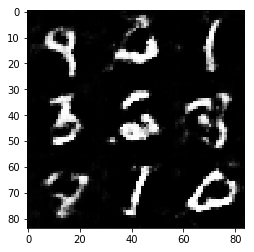

Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 1.2905
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.4638
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 1.7854
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 1.4116
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.4865


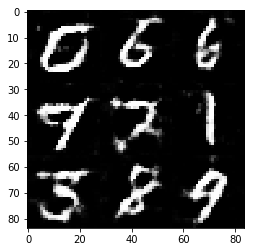

Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 1.1361
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.4120
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 1.9042


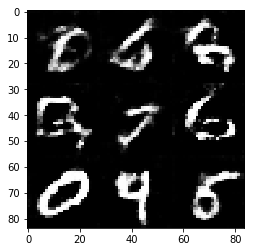

Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 2.0883... Generator Loss: 0.1775
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.4817
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 2.1020... Generator Loss: 2.2339
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.5777


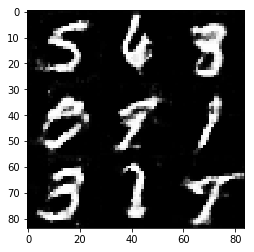

Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 1.7246... Generator Loss: 0.2474
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 0.6776


In [68]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5280... Generator Loss: 0.0434
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 4.8739
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 1.8600
Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 1.4857
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8660


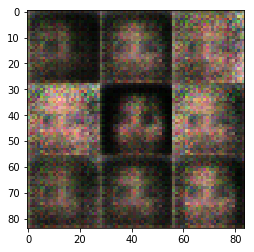

Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.7964... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7505


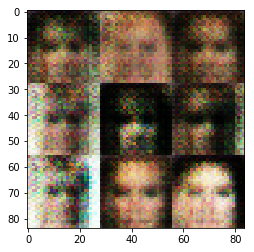

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8594


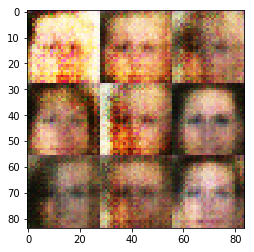

Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.6491


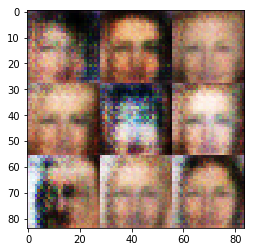

Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7662


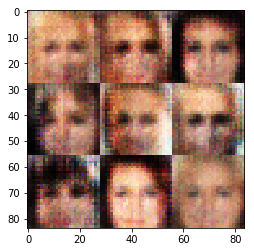

Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7281


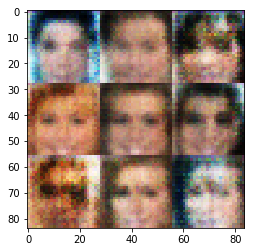

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7156


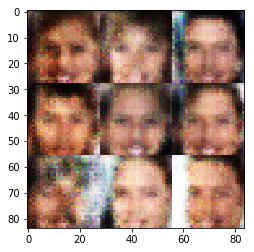

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7289


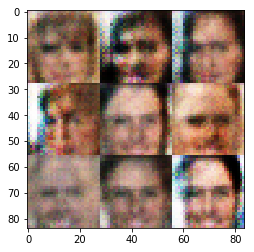

Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6906


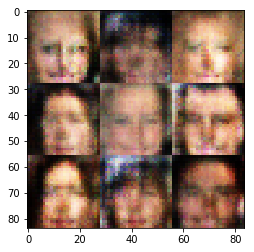

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6840


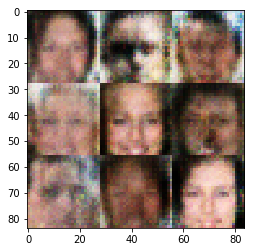

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6550


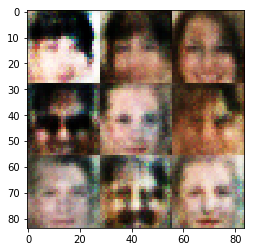

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6926


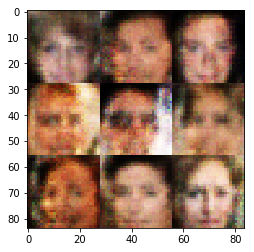

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6638


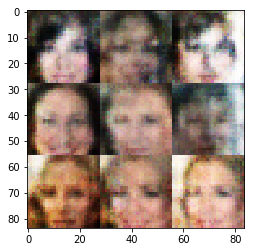

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6688


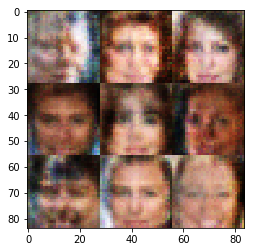

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6811


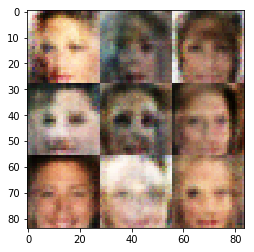

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6925


In [69]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.